## **Prep**

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## **Data collecting**

In [ ]:
drive.mount('/content/drive')
os.listdir('/content/drive/MyDrive')
file_path = '/content/drive/MyDrive/data set/nyc_taxi_data_2014.csv'
df_taxi = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-fd04744bfedb>:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_taxi = pd.read_csv(file_path)


## **Data Cleaning**

In [ ]:
df_taxi['store_and_fwd_flag'].fillna('N', inplace=True)
df_taxi.dropna(subset=['dropoff_longitude', 'dropoff_latitude'], inplace=True)
df_taxi['pickup_datetime'] = pd.to_datetime(df_taxi['pickup_datetime'])
df_taxi['dropoff_datetime'] = pd.to_datetime(df_taxi['dropoff_datetime'])
df_taxi['trip_duration'] = (df_taxi['dropoff_datetime'] - df_taxi['pickup_datetime']).dt.total_seconds()
df_taxi['trip_duration_min'] = (df_taxi['trip_duration'] / 60).round(1)
df_taxi = df_taxi[(df_taxi['trip_duration_min'] > 0) & (df_taxi['trip_distance'] > 0)]
df_taxi['pickup_hour'] = df_taxi['pickup_datetime'].dt.hour
df_taxi['pickup_dayofweek'] = df_taxi['pickup_datetime'].dt.dayofweek
df_taxi = df_taxi.dropna(thresh=5)
#-------------------------------------------------------------------------------------------------------------------
min_duration = 1
max_duration = 180
df_taxi = df_taxi[(df_taxi['trip_duration_min'] >= min_duration) & (df_taxi['trip_duration_min'] <= max_duration)]
#-------------------------------------------------------------------------------------------------------------------
df_taxi = df_taxi[
    (df_taxi['trip_duration'] > 0) &
    (df_taxi['trip_duration'] <= 7200) &
    (df_taxi['passenger_count'] > 0) &
    (df_taxi['passenger_count'] <= 6)]


<ipython-input-4-2e18eae6ce83>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_taxi['store_and_fwd_flag'].fillna('N', inplace=True)


In [ ]:
dropable=['passenger_count', 'rate_code', 'store_and_fwd_flag', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount' ]
df_taxi = df_taxi.drop(columns=dropable)
#-------------------------------------------------------------------------------------------------------------------
valid_longitude = (-74.5, -73.5)
valid_latitude = (40.5, 41.0)

df_taxi = df_taxi[
    (df_taxi['pickup_longitude'].between(*valid_longitude)) &
    (df_taxi['dropoff_longitude'].between(*valid_longitude)) &
    (df_taxi['pickup_latitude'].between(*valid_latitude)) &
    (df_taxi['dropoff_latitude'].between(*valid_latitude))
]

print("Remaining rows after removing invalid geo coordinates:", len(df_taxi))

Remaining rows after removing invalid geo coordinates: 14692571


# **Exploratory Data Analysis**

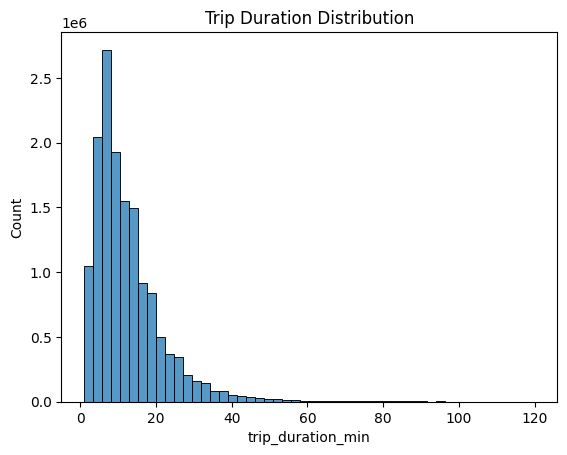

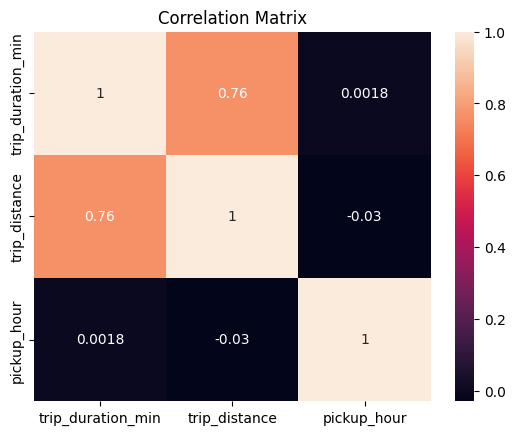

In [ ]:

sns.histplot(df_taxi['trip_duration_min'], bins=50)
plt.title('Trip Duration Distribution')
plt.show()

corr = df_taxi[['trip_duration_min', 'trip_distance', 'pickup_hour']].corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix')
plt.show()

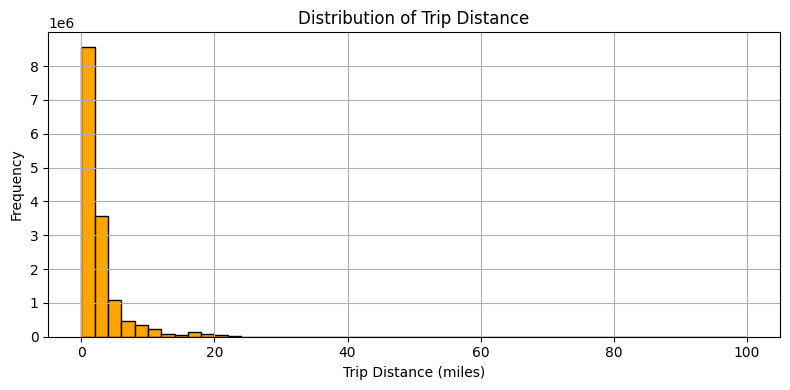

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(df_taxi['trip_distance'], bins=50, color='orange', edgecolor='black')
plt.title('Distribution of Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

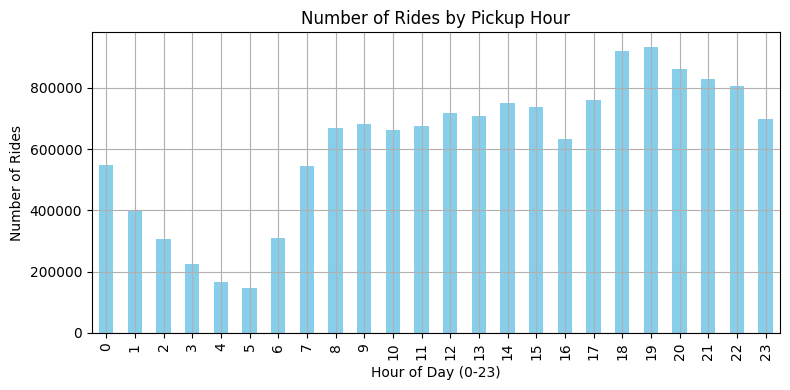

In [ ]:
plt.figure(figsize=(8, 4))
df_taxi['pickup_hour'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Rides by Pickup Hour')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.tight_layout()
plt.show()

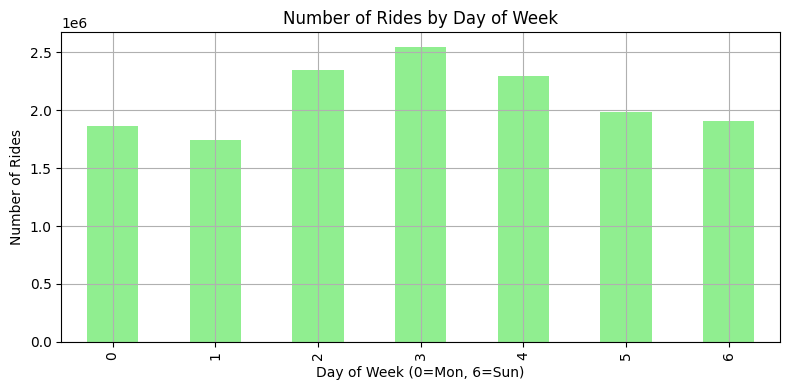

In [ ]:
plt.figure(figsize=(8, 4))
df_taxi['pickup_dayofweek'].value_counts().sort_index().plot(kind='bar', color='lightgreen')
plt.title('Number of Rides by Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Seperation**


In [ ]:
df_sample = df_taxi.sample(n=100_000, random_state=42)

In [ ]:
features = [
    'trip_distance',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'pickup_hour', 'pickup_dayofweek'
]
target = 'trip_duration_min'

In [ ]:
X = df_sample[features]
y = df_sample[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# **ML**

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} minutes")
print(f"RMSE: {rmse:.2f} minutes")
print(f"R² Score: {r2:.4f}")

MAE: 2.75 minutes
RMSE: 4.49 minutes
R² Score: 0.7678
